# Week 4 - Partial Least Squares Regression

We will reimplement and then explore some of the properties of [Cosgrove et al](http://pubs.rsc.org/en/Content/ArticleLanding/2010/MB/b926287c).

In [1]:
import scipy as sp, numpy as np
import numpy as np
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.io import loadmat
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
import matplotlib.pyplot as plt
from scipy.stats import kstest, ttest_ind, ks_2samp, zscore
data = sp.io.loadmat('wk4_Cosgrove-data.mat', squeeze_me=True)['s']

X = data['X'].item() # the untransformed data matrix (66x102)
Y = data['Y'].item() # the untransformed LDH release at 48hours. (66x1)
phosphoproteins = data['phosphoproteins'].item() # names of phosphoproteins
conditions = data['conditions'].item() # cell array of the 66 conditions
drugList = data['drugList'].item() # description of the drugs used in each of the 66 conditions
drugListToxic = data['drugListToxic'].item() # binary value corresponding to whether drugList[i] is toxic
drugs = data['drugs'].item() # binary matrix mapping which measurements correspond to a drug treatment in drugList
cytokineList = data['cytokineList'].item() # cell array of cytokine treatments
ind4pProtein = data['ind4pProtein'].item() # the column indices corresponding to measurements of the 4 phosphoprotein subset

#### (1) Perform PLSR on the matrixes X and Y. Plot the percent variance explained. How many principal components do you need for each to explain 90% of the Y variance? Discuss your findings.

Hint: Be sure you are normalizing each dataset as needed for the analysis.

PLSR R2Y: [0.01       0.68497463 0.80968225 0.89212484 0.92319831 0.94200853
 0.95420744 0.96121885 0.96891094 0.97423581]


Text(0.5, 0, 'number of principle components')

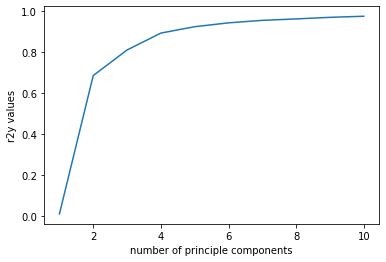

In [32]:
y = Y[:,4]
r2y = np.empty(10)
n_components= np.empty(10)
for i in range(1,10):
    normofX = zscore(X,axis = 0)
    model = PLSRegression(n_components=i)
    model.fit(normofX,y)
    r2y[i] = model.score(normofX,y)
    
print(f'PLSR R2Y: {r2y}')
plt.plot(np.linspace(1,10,10),r2y)
plt.ylabel('r2y values')
plt.xlabel('number of principle components')
#You need at least 4 principle components to explain 90% of the Y variance. Past 4 principle components, 
#the r2y value score levels out, with little gain. 

#### (2) How would you expect the percent of X variance explained to compare between PLSR and PCA? Why?

The percent of X variance would increase for PCA, since only the covariance is maximized for PLSR. On the other hand, PCA only accounts for variance in X. 

#### (3) Recreate the Figure S2A plot from Cosgrove et al. supplementary information. This is the PLSR scores plot (for PC1 and PC2), with toxic drugs colored according to the drug type and all other drugs are not colored. Use the drugList, drugListToxic to identify these categories.

['DMSO' 'CIM' 'RAN' 'LEV' 'TRO' 'BUS' 'NEF' 'ASP' 'NIM' 'CLA' 'TEL']
[0 0 1 0 1 0 1 0 1 1 1]


(-10.0, 25.0)

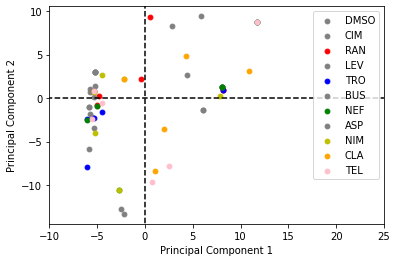

In [35]:
scores = model.y_scores_
color = ['gray','gray','r','gray','b','gray','g','gray','y','orange','pink']

print(drugList)
print(drugListToxic)

n = 0
for i in range(11):
    plt.scatter(scores[n:n+6, 0], scores[n:n+6, 1],c = color[i],label = drugList[i],s=23)
    i = i+1
    n = n+6
plt.legend()

ylim, xlim = plt.ylim(), plt.xlim(-10,25)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.plot([0, 0], [-100, 100], linestyle='--', color='k')
plt.plot([-100, 100], [0, 0], linestyle='--', color='k')
plt.ylim(ylim)
plt.xlim(xlim)

#### (4) Create the loadings plot corresponding to (2). Interpret the results shown on the plot.

(102, 9)


(-0.2, 0.5)

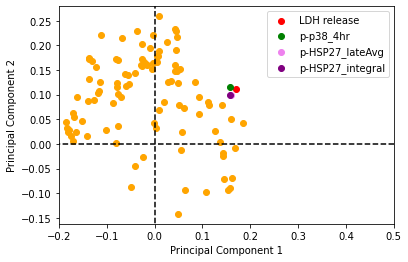

In [33]:
yloadings = model.y_loadings_
xloadings = model.x_loadings_

print(np.shape(xloadings))
plt.scatter(yloadings[:, 0],yloadings[:, 1],c = 'red',label = 'LDH release')
color = ['green','violet','purple','gold','teal','salmon','black','skyblue']
n = -1
for i in range(len(xloadings)):
    if xloadings[i,0]>.12 and xloadings[i,1]>0.08:
        n = n+1
        plt.scatter(xloadings[i, 0],xloadings[i, 1],c = color[n],label = phosphoproteins[i])
    else:
        plt.scatter(xloadings[i, 0],xloadings[i, 1],c = 'orange')

plt.legend()


ylim, xlim = plt.ylim(), plt.xlim(-.20,.50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.plot([0, 0], [-100, 100], linestyle='--', color='k')
plt.plot([-100, 100], [0, 0], linestyle='--', color='k')
plt.ylim(ylim)
plt.xlim(xlim)

#The P-p38_4hr, p_HSP27_lateAve, and the p_HSP27_integral all are in the 
#same area as LDH release. They affect both PC1 and PC2 the most positively 
#when combined and this results in an increase in LDH release. 

#### (5) Add the variance of the loadings to your loadings plot (this can be shown as error bars). How does the variance of component one compare to that of component two? Would you expect a trend in the general variance versus component number?

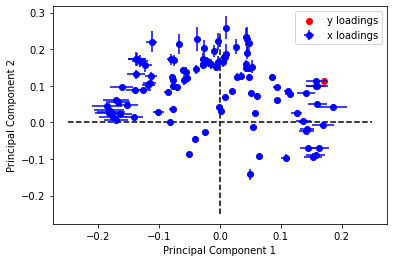

In [34]:
n = 300

newxloadingspc1 = ()
newxloadingspc2 = ()


from sklearn.utils import resample

xnew = np.zeros((100,102,4))
ynew = np.zeros((100,1,4))


for trial in range(100):
    boot_X,boot_Y = resample(X,y)
    boot_X = zscore(boot_X)
    model = PLSRegression(n_components=4)
    model.fit(boot_X,boot_Y)
    xnew[trial] = model.x_loadings_
    ynew[trial] = model.y_loadings_

xloadingpc1 = np.zeros(102)
xloadingpc2 = np.zeros(102)

for i in range(102): 
    xloadingpc1[i] = np.var(xnew[:,i,0])
    xloadingpc2[i] = np.var(xnew[:,i,1])

plt.errorbar(xloadings[:,0],xloadings[:,1],xerr=xloadingpc1,yerr=xloadingpc2,fmt = 'o',color = 'blue',label = 'x loadings')
plt.scatter(yloadings[:,0],yloadings[:,1],color = 'red',label = 'y loadings')
plt.plot([0,0],[-0.25,0.25],linestyle = '--',color = 'k')
plt.plot([-0.25,0.25],[0,0],linestyle = '--',color = 'k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

#The variance of component 2 appears larger than the variance for component 1. 
#I would expect a trend in the number of components and the amount of variance 
#since a system dependent on more components is bound to have wider variation. 

#### (6) Recreate a 4-principal component model using PLSR with just the final 4 phosphoprotein model. Plot predicted v. observed LDH for this model. Report the model fitness ($R^2$). Define here how you are calculating $R^2$.

the model fitness is 0.8821898904528919


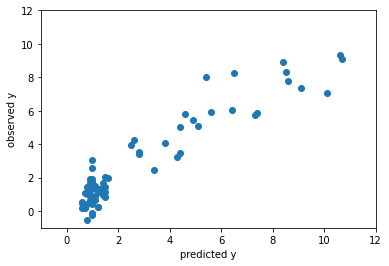

In [36]:
newX = np.empty((66,24),float)

for i in range(24):
    phospho = ind4pProtein[i]
    onlyX = normofX[:,phospho]
    newX[:,i]= onlyX

newYs = np.zeros(24)
pls = PLSRegression(n_components = 4)
pls.fit(newX,y)
newYs = pls.predict(newX)
plt.scatter(y,newYs)
plt.xlim(-1,12)
plt.ylim(-1,12)
plt.xlabel('predicted y')
plt.ylabel('observed y')

r2y = pls.score(newX,y)
print('the model fitness is',r2y)
#I am calculating r2y by taking the sum of squares for the variation 
#in the Y matrix. 

#### (7) Cosgrove *et al* discusses their method for model validation using leave-one-out cross-validation. Calculate all LDH predictions for leave-one-out cross-validation and calculate the R^2 value for the resulting yfit values. What is the R^2 value? Why do you think it’s important to perform cross-validation?

0.9712471169321527


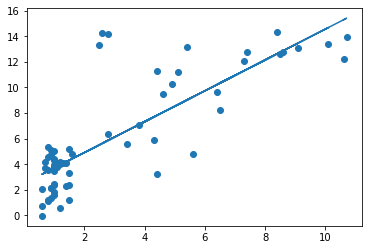

In [21]:
#the R^2 value is the total variation in the Y matrix that can be predicted. 
#It is important to perform cross-validation in order to be able to judge
#the accuracy of our predictions. 



from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

tree = np.empty((66,24),float)

for i in range(24):
    phospho = ind4pProtein[i]
    onlytree = X[:,phospho]
    tree[:,i]= onlytree

    #tree is the new X with the ind4Proteins (66,24)
def q2y(y,cvYs):
    answer = (1 - (np.sum((cvYs-y)**2)) / (np.sum(y)**2))
    return answer

cvYs = np.zeros(len(y))

for train_index, test_index in loo.split(tree,y): 
    X_train, X_test = tree[train_index],tree[test_index]
    X_train = zscore(X_train)
    Y_train, Y_test = y[train_index],y[test_index]
    
    plscv = PLSRegression(n_components = 4)
    pls.fit(X_train,Y_train)
    cvYs[test_index] = pls.predict(X_test)
    
q2youtput = q2y(y,cvYs)

m,b = np.polyfit(y,cvYs,1)
plt.scatter(y,cvYs)
plt.plot(y,m*y+b)
print(q2youtput)

8) Now, instead of performing LOOCV, let's perform leave-one-cytokine-out cross-validation. That is, one cytokine at a time, leave out all the data for the NoCyt, IL-1, LPS, TNF, IL-6, or Mix conditions.
Hint: Look at sklearn.model_selection.LeaveOneGroupOut
Hint: Look at `sklearn.model_selection.LeaveOneGroupOut`.

How does this affect your cross-validation? How do the two approaches here differ? When might each be most appropriate?

the value of Q2Y is: 0.9577577234826369


Text(0.5, 0, 'Observed')

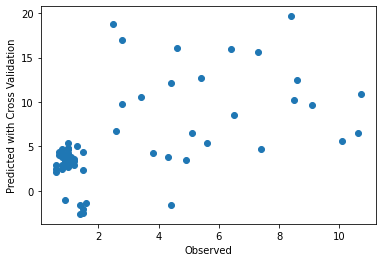

In [24]:
from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()
ypredicted = np.zeros((6,11))
groups = np.tile(np.arange(1,7),11)

i = 0

for train_index,test_index in logo.split(tree,y,groups=groups): 
    X_train,X_test = tree[train_index],tree[test_index]
    X_train = zscore(X_train)
    Y_train,Y_test = y[train_index],y[test_index]
    
    eight = PLSRegression(n_components=4)
    eight.fit(X_train,Y_train)
    ypredicted[i] = eight.predict(X_test)[:,0]
    i = i+1

ypredicted = ypredicted.flatten(order='F')

q2youtput = q2y(y,ypredicted)
print('the value of Q2Y is:',q2youtput)
plt.scatter(y,yfit)

plt.ylabel('Predicted Y with Cross Validation')
plt.xlabel('Observed Y')

#This affects cross validation by giving a smaller Q2Y, which 
#makes sense because by grouping we are creating a smaller sample size 
#because more of the data set is left out for each fold. The two 
#approaches differ in that this approach involves holding back a group of 
#values as the test set for each fold, whereas number seven only held
#a single index of the array as the test set. In this case, to maximize Q2Y
#the method in seven seems more appropriate. 